Presentation date: July 5, 2022

# Regression Discontinuity Design - COVID19 Analysis

The objective of this group project was to use regression discontinuity design to visualize the effects of three measures taken to mitigate the spread of COVID19 in the province of Quebec. These events were:
- The March 2020 lockdown
- The reopening of schools at the end of August 2020
- The Christmas 2020 lockdown 

### Design

We first found a dataset that contained information relating to COVID19 cases in Quebec. We narrowed our analysis down to either an analysis of daily deaths or daily new cases - we used visualizations to determine which trends were more consistent and better establish a basis of comparison. We also used a one-week rolling average of daily cases to better view the trend. Then we built regression models around each of the three events and compared before and after the date of interest, visualizing the regression line against the rolling average.

### Conclusions

For each event, there appears to be a significant effect of the actions taken on the progression of COVID19 cases. 

#### March 2020
As seen below, the rate of case growth slowed from its initial exponential growth to a much more gradual growth ("flattening the curve"). 

#### August 2020
The regression lines show a very clear upward trend in case counts after schools reopened in August 2020.

#### December 2020
The regression lines show an upward trend prior to the lockdown, and a downward trend after. 

In [134]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as sc
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
# Silence those pesky warnings
import warnings
warnings.filterwarnings('ignore')

In [135]:
# The 20/3/2020 lockdown
# The reopening of schools on 31/8/2020
# The 25/12/2020 lockdown

# Create datetime objects for easier manipulation

lock1 = dt.datetime(year=2020, month=3, day=20)
reopen = dt.datetime(year=2020, month=8, day=31)
lock2 = dt.datetime(year=2020, month=12, day=25)

In [136]:
data = pd.read_csv('../data/covid1.csv')

In [137]:
# Prune unnecessary columns
data = data.drop(columns=['Cumulative Cases', 'Cumulative Death', 'Active Cases'])

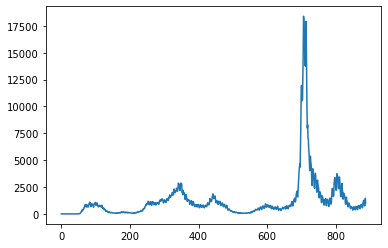

In [138]:
# Quick visual look at the date
data['New Cases'].plot()
# Create rolling averages
data['rollcase']=data.rolling(window = 7, center=True).mean()['New Cases']
data['rolldeath']=data.rolling(window = 7, center=True).mean()['Daily Deaths']

In [139]:
# Convert date to datetime, set as index
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')

# Create three subsets of data comprising 30 days before/after each event of interest

df1 = data.loc[(lock1 - dt.timedelta(30) < data.index) & (data.index < lock1 + dt.timedelta(30))]
df2 = data.loc[(reopen - dt.timedelta(30) < data.index) & (data.index < reopen + dt.timedelta(30))]
df3 = data.loc[(lock2 - dt.timedelta(30) < data.index) & (data.index < lock2 + dt.timedelta(30))]

<AxesSubplot:xlabel='Date'>

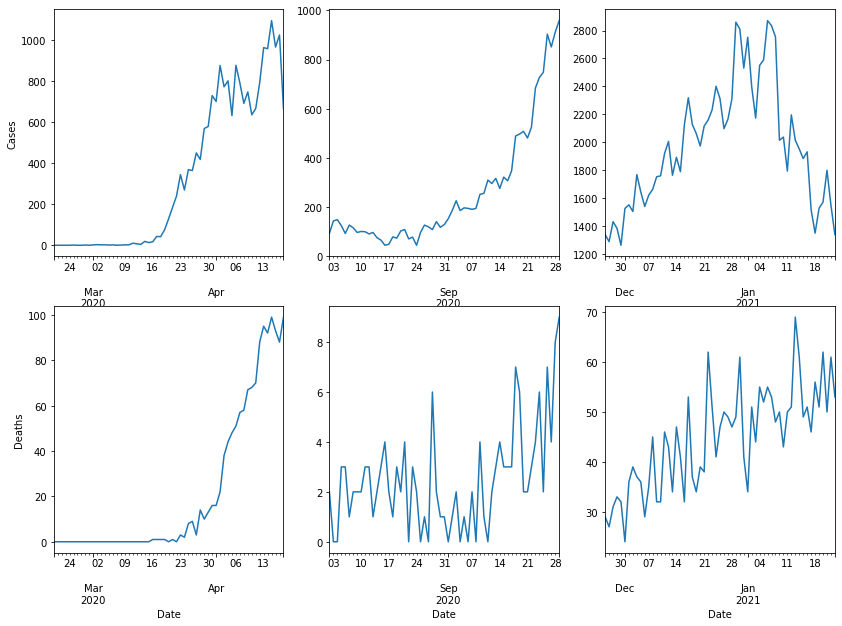

In [140]:
# Visualize each event in terms of new cases and deaths respectively

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(14,10))
df1['New Cases'].plot(ylabel='Cases',ax=ax1)
df1['Daily Deaths'].plot(ylabel= 'Deaths', ax=ax4)
df2['New Cases'].plot(ax=ax2)
df2['Daily Deaths'].plot(ax=ax5)
df3['New Cases'].plot(ax=ax3)
df3['Daily Deaths'].plot(ax=ax6)

<AxesSubplot:xlabel='Date'>

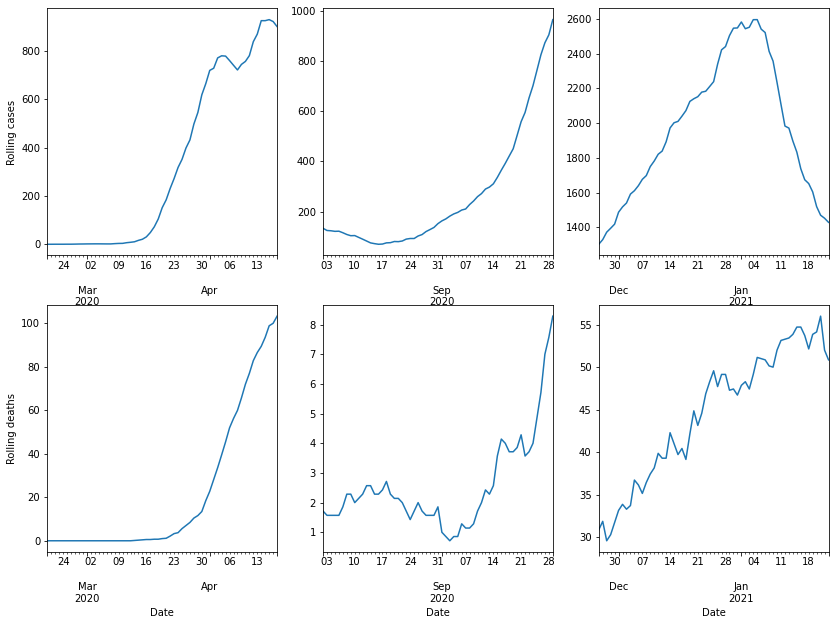

In [141]:
# Visualize each event in terms of rolling averages of new cases and deaths

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(14,10))
df1['rollcase'].plot(ylabel='Rolling cases', ax=ax1)
df1['rolldeath'].plot(ylabel='Rolling deaths', ax=ax4)
df2['rollcase'].plot(ax=ax2)
df2['rolldeath'].plot(ax=ax5)
df3['rollcase'].plot(ax=ax3)
df3['rolldeath'].plot(ax=ax6)

In [142]:
# Simple function for modelling and plotting 

def plotreg(df, ax, poly=True, l2=False):
    # Flag to use ridge regression or not to smoothe the polynomial 
    if l2 == False:
        model = LinearRegression()
    else:
        model = Ridge(alpha=15)
    # define X values
    X = df.day_count.values.reshape(-1, 1)
    # Polynomial flag - if true, regression will be a curve instead of a line
    if poly == True:
        X = np.c_[X, X**2]
    # y values are set to new cases
    y = df['New Cases'].values.reshape(-1, 1)
    model.fit(X, y)
    # predicted y values will be plotted 
    y_pred = model.predict(X)
    # Plot the regression 
    ax.plot(df.index, y_pred, c='r', lw=3)
    # Plot the rolling average
    ax.scatter(df.index, df.rollcase, c='b')
    # Uncomment below to check the coeffients
#     print(model.coef_) 
    return ax

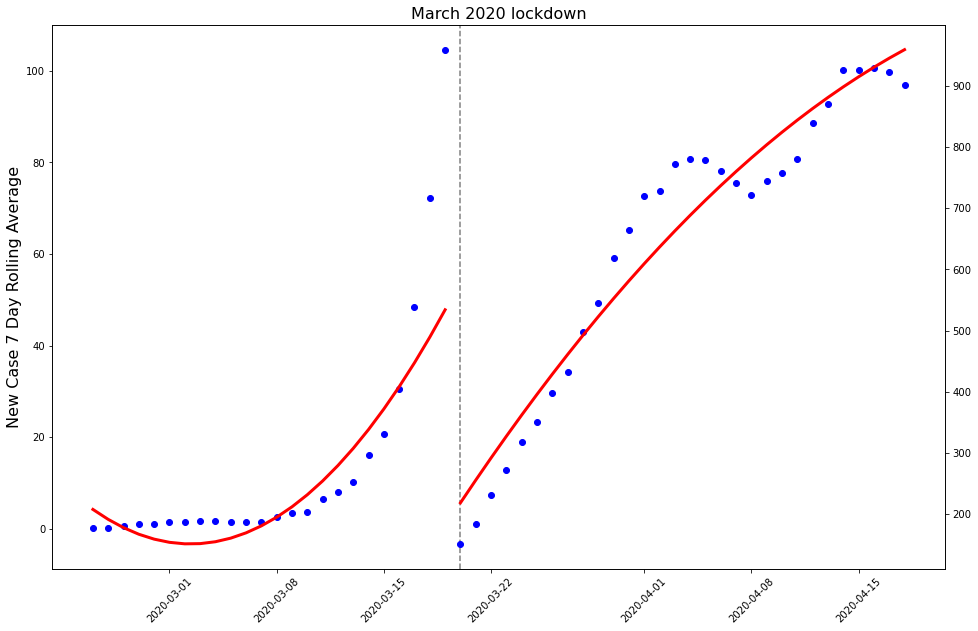

In [148]:
# Split the data set into before and after event of interest
df1['day_count'] = [n for n in range(len(df1))]
df1a = df1.loc[df1.index < lock1]
df1b = df1.loc[df1.index >= lock1]

# Get rid of the first few days - no cases
df1a = df1a[5:]

# Create figure and designate the axes object
_, ax = plt.subplots(figsize=(16,10))
plt.xticks(rotation = 45)

ax1 = ax.twinx() # Use 2 y axes - the scale of the data will obscure the left side otherwise

# Call the function to model and plot for each half of the data
plotreg(df1a, ax, l2=True)
plotreg(df1b, ax1, l2=True)

# Set label, title, and line to indicate the event
ax.set_ylabel('New Case 7 Day Rolling Average', size=16)
ax.set_title('March 2020 lockdown', size=16)
ax.axvline(lock1, ls='--', c='grey')
plt.show()

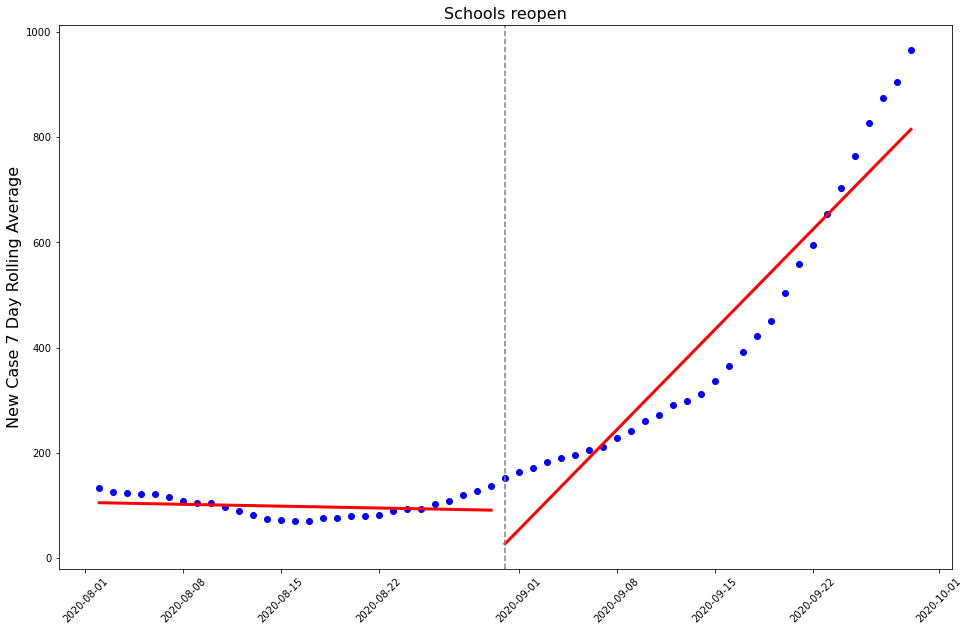

In [144]:
df2['day_count'] = [n for n in range(len(df2))]
df2a = df2.loc[df2.index < reopen]
df2b = df2.loc[df2.index >= reopen]

_, ax = plt.subplots(figsize=(16,10))
plt.xticks(rotation = 45)
plotreg(df2a, ax, poly=False, l2=False)
plotreg(df2b, ax, poly=False, l2=False)
ax.set_ylabel('New Case 7 Day Rolling Average', size=16)
ax.axvline(reopen, ls='--', c='grey')
ax.set_title('Schools reopen', size=16)
plt.show()

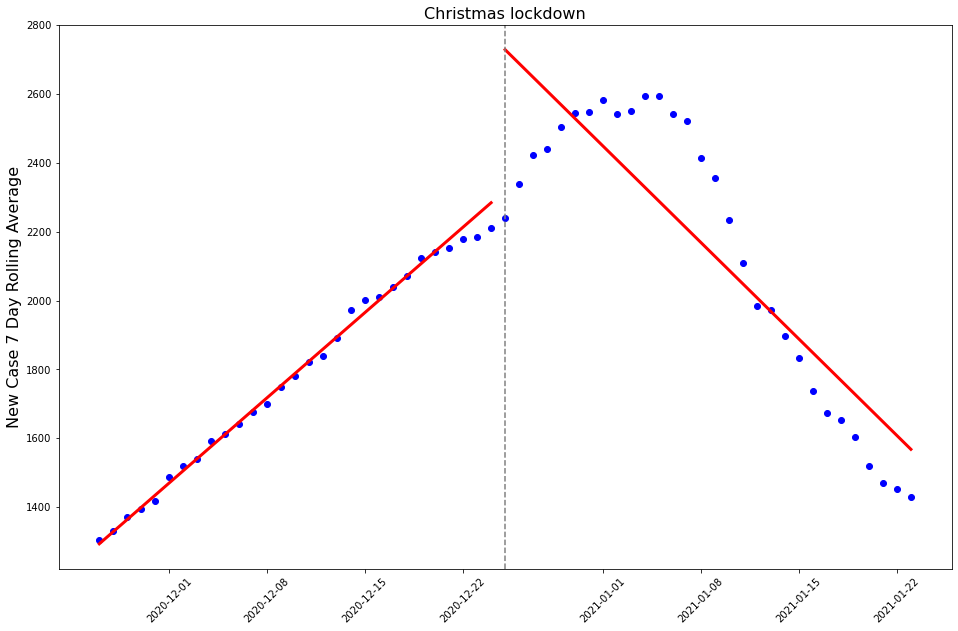

In [145]:
df3['day_count'] = [n for n in range(len(df3))]
df3a = df3.loc[df3.index < lock2]
df3b = df3.loc[df3.index >= lock2]

_, ax = plt.subplots(figsize=(16,10))
plt.xticks(rotation = 45)
plotreg(df3a, ax, poly=False)
plotreg(df3b, ax, poly=False)
ax.set_ylabel('New Case 7 Day Rolling Average', size=16)
ax.axvline(lock2, ls='--', c='grey')
ax.set_title('Christmas lockdown', size=16)
plt.show()

In [146]:
# T-tests to compare populations prior to and following the events of interest
# p-values <.05 indicate a significant difference 

print(sc.ttest_ind(df1a['New Cases'], df1b['New Cases']))
print(sc.ttest_ind(df2a['New Cases'], df2b['New Cases']))
print(sc.ttest_ind(df3a['New Cases'], df3b['New Cases']))

Ttest_indResult(statistic=-11.782878165578328, pvalue=2.6722182143337777e-16)
Ttest_indResult(statistic=-6.747499040697997, pvalue=8.373836154934223e-09)
Ttest_indResult(statistic=-3.398425244354216, pvalue=0.0012424147507321584)
